# 1. Scrape data from website

In [15]:
%echo
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from plotnine import *

ECHO is on.


In [16]:
url = "https://tastesbetterfromscratch.com/meal-plan-207"
headers ={ "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)" }

req = requests.Session()

# get the html content
response = req.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")


In [17]:
meals = soup.find_all("p", class_ = "has-text-align-left")
meals

[<p class="has-text-align-left"><strong>Monday</strong>: <a href="https://tastesbetterfromscratch.com/salmon-tacos/">Salmon Tacos</a> $25.79</p>,
 <p class="has-text-align-left"><strong>Tuesday</strong>: <a href="https://tastesbetterfromscratch.com/mediterranean-meatball-bowl/">Mediterranean Meatball Bowl</a> $14.24</p>,
 <p class="has-text-align-left"><strong>Wednesday: </strong><a href="https://tastesbetterfromscratch.com/boursin-pasta/">Boursin Pasta</a> $13</p>,
 <p class="has-text-align-left"><strong>Thursday:</strong> <a href="https://tastesbetterfromscratch.com/cevapi/">Cevapi</a> $31</p>,
 <p class="has-text-align-left"><strong>Friday:</strong> <a href="https://tastesbetterfromscratch.com/panang-curry/">Panang Curry</a> $21.82</p>]

In [18]:
rows = []
for meal in meals:
  day = meal.find("strong").text.split(":")[0]

  recipe = meal.find("a", href = True)

  recipe_name = recipe.text

  recipe_url = recipe["href"]
  
  price = meal.text.split(" ")[-1]

  rows.append({"Day": day, "Recipe Name": recipe_name, "Link": recipe_url, "Price": price})

rows



[{'Day': 'Monday',
  'Recipe Name': 'Salmon Tacos',
  'Link': 'https://tastesbetterfromscratch.com/salmon-tacos/',
  'Price': '$25.79'},
 {'Day': 'Tuesday',
  'Recipe Name': 'Mediterranean Meatball Bowl',
  'Link': 'https://tastesbetterfromscratch.com/mediterranean-meatball-bowl/',
  'Price': '$14.24'},
 {'Day': 'Wednesday',
  'Recipe Name': 'Boursin Pasta',
  'Link': 'https://tastesbetterfromscratch.com/boursin-pasta/',
  'Price': '$13'},
 {'Day': 'Thursday',
  'Recipe Name': 'Cevapi',
  'Link': 'https://tastesbetterfromscratch.com/cevapi/',
  'Price': '$31'},
 {'Day': 'Friday',
  'Recipe Name': 'Panang Curry',
  'Link': 'https://tastesbetterfromscratch.com/panang-curry/',
  'Price': '$21.82'}]

In [19]:
meal_plan = pd.DataFrame(rows)
meal_plan

,Day,Recipe Name,Link,Price
0,Monday,Salmon Tacos,https://tastesbetterfromscratch.com/salmon-tacos/,$25.79
1,Tuesday,Mediterranean Meatball Bowl,https://tastesbetterfromscratch.com/mediterran...,$14.24
2,Wednesday,Boursin Pasta,https://tastesbetterfromscratch.com/boursin-pa...,$13
3,Thursday,Cevapi,https://tastesbetterfromscratch.com/cevapi/,$31
4,Friday,Panang Curry,https://tastesbetterfromscratch.com/panang-curry/,$21.82


# 2. Data from API

In [20]:
# base endpoint + "recipes/list"
url = "https://tasty.p.rapidapi.com/recipes/list"

# possible query arguments:
# from = which page of the repsonse?
# size = how many elements do you want
# q = specific quer/keyword you're searching for

monday_recipe = meal_plan["Recipe Name"][0]
querystring = {"from":"0","size":"20","q": monday_recipe}

# headers of your request: your key that allows access, and the host you're entering through
headers = {
    "X-RapidAPI-Key": "fab50fb816mshd6c9a236b82e602p130fe1jsnb382b621ce28",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

# get request
response = requests.get(url, headers=headers, params=querystring)


In [21]:
api_recipe_table = pd.json_normalize(response.json(), "results")
api_recipe_table.head()

,approved_at,aspect_ratio,beauty_url,brand,brand_id,buzz_id,canonical_id,compilations,cook_time_minutes,country,...,show.name,tips_summary.by_line,tips_summary.content,tips_summary.header,total_time_tier.display_tier,total_time_tier.tier,user_ratings.count_negative,user_ratings.count_positive,user_ratings.score,recipes
0,1566180267,16:9,None,NaN,NaN,None,recipe:5507,"[{'approved_at': 1669843672, 'aspect_ratio': '...",0.0,US,...,Tasty,Powered By Botatouille,• Reduce the amount of spices used for a milde...,Highlights,Under 30 minutes,under_30_minutes,81.0,953.0,0.921663,NaN
1,1614041349,16:9,None,NaN,NaN,None,recipe:7121,[],13.0,US,...,Tasty,NaN,NaN,NaN,Under 30 minutes,under_30_minutes,3.0,20.0,0.869565,NaN
2,1594990985,1:1,None,NaN,NaN,None,compilation:1578,NaN,NaN,US,...,Tasty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 66, '_index': 'recipes-20241125172232..."
3,1561604721,1:1,None,NaN,NaN,None,compilation:989,NaN,NaN,US,...,Tasty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'_id': 66, '_index': 'recipes-20241125172232..."


# 3. automate it + 4. Fuzzy Matching for Vegetarian

In [22]:
def get_weekly_plan(num):
  url = "https://tastesbetterfromscratch.com"
  headers ={ "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)" }

  req = requests.Session()

  # get the html content

  response = req.get(url + f"/meal-plan-{num}", headers=headers)
  soup = BeautifulSoup(response.content, "html.parser")

  meals = soup.find_all("p", class_ = "has-text-align-left")

  rows = []
  for meal in meals:
    day = meal.find("strong").text.split(":")[0]


    recipe = meal.find("a", href = True)
    recipe_name = recipe.text
    if re.findall(r"Chicken|Beef|Steak|Ham|Pork|Turkey|Mutton|Lamb|Meatball", recipe_name):
      vegetarian = "No"
    else:
      vegetarian = "Yes"
    recipe_url = recipe["href"]

    price = float(meal.text.split("$")[-1])

    rows.append({"Day": day, "Recipe Name": recipe_name, "Link": recipe_url, "Price ($)": price, "Vegetarian?": vegetarian})

  meal_plan = pd.DataFrame(rows)
  return meal_plan


In [23]:
get_weekly_plan(202)

,Day,Recipe Name,Link,Price ($),Vegetarian?
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,10.82,No
1,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,No
2,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Yes
3,Thursday,Vegetarian Stuffed Peppers,https://tastesbetterfromscratch.com/southwest-...,19.60,Yes
4,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,No


In [24]:
def match_recipe(weekly_plan, day_num):
  # base endpoint + "recipes/list"
  url = "https://tasty.p.rapidapi.com/recipes/list"

  day_recipe = weekly_plan["Recipe Name"][day_num]

  querystring = {"from":"0","size":"20","q": day_recipe}

  # headers of your request: your key that allows access, and the host you're entering through
  headers = {
      "X-RapidAPI-Key": "fab50fb816mshd6c9a236b82e602p130fe1jsnb382b621ce28",
      "X-RapidAPI-Host": "tasty.p.rapidapi.com"
  }

  # get request
  response = requests.get(url, headers=headers, params=querystring)

  df = pd.json_normalize(response.json(), "results")
  return df

In [25]:
def get_mealplan_data(num):
  weekly_plan = get_weekly_plan(num)

  tasty_matches = []
  for i in range(0, 5):
    matches = match_recipe(weekly_plan, i)
    if matches.empty:
      nutrition_info = {"Tasty Match Name": "No matches found", "# of Servings": np.nan, "Calories": np.nan, "Carbs (g)": np.nan, "Fat (g)": np.nan,
                        "Fiber (g)": np.nan, "Protein (g)": np.nan, "Sugar (g)": np.nan}
    else:
      #take first row of matches
      first_match = matches.iloc[0, :]
      nutrition_info = {"Tasty Match Name": first_match["name"], "# of Servings": first_match["num_servings"], "Calories": first_match["nutrition.calories"], "Carbs (g)": first_match['nutrition.carbohydrates'], "Fat (g)": first_match['nutrition.fat'],
                        "Fiber (g)": first_match['nutrition.fiber'], "Protein (g)": first_match['nutrition.protein'], "Sugar (g)": first_match['nutrition.sugar']}

    tasty_matches.append(nutrition_info)

  tasty_matches_df = pd.DataFrame(tasty_matches)

  return pd.concat([weekly_plan, tasty_matches_df], axis = 1)


In [26]:
df202 = get_mealplan_data(202)
df202

,Day,Recipe Name,Link,Price ($),Vegetarian?,Tasty Match Name,# of Servings,Calories,Carbs (g),Fat (g),Fiber (g),Protein (g),Sugar (g)
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,10.82,No,No matches found,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,No,Taiwanese Beef Noodle Soup,6.0,887.0,81.0,33.0,9.0,68.0,15.0
2,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Yes,Meatball Stuffed Shell Pasta,4.0,1500.0,113.0,72.0,7.0,99.0,17.0
3,Thursday,Vegetarian Stuffed Peppers,https://tastesbetterfromscratch.com/southwest-...,19.60,Yes,Creamy Spinach-Stuffed Mushrooms,5.0,226.0,12.0,17.0,1.0,7.0,3.0
4,Friday,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,21.22,No,Chicken Gyros,8.0,510.0,50.0,15.0,3.0,43.0,17.0


In [27]:
get_mealplan_data(111)

,Day,Recipe Name,Link,Price ($),Vegetarian?,Tasty Match Name,# of Servings,Calories,Carbs (g),Fat (g),Fiber (g),Protein (g),Sugar (g)
0,Monday,Turkey Chili,https://tastesbetterfromscratch.com/turkey-chi...,15.77,No,Slow Cooker Turkey Chili With Cornbread Dumplings,6.0,662.0,73.0,27.0,14.0,41.0,13.0
1,Tuesday,Skillet Lasagna,https://tastesbetterfromscratch.com/one-pan-sk...,10.93,Yes,Lasagna Skillet Pasta,4.0,847.0,66.0,40.0,4.0,59.0,13.0
2,Wednesday,Pollo Fundido,https://tastesbetterfromscratch.com/pollo-fund...,11.17,Yes,No matches found,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thursday,Creamy Tomato and Spinach Tortellini,https://tastesbetterfromscratch.com/creamy-tom...,9.18,Yes,Beef and Cheese Tortellini Bake,6.0,706.0,43.0,38.0,4.0,46.0,6.0
4,Friday,Pot Roast,https://tastesbetterfromscratch.com/slow-cooke...,29.81,Yes,The Best Ever Slow Cooker Pot Roast,5.0,652.0,31.0,18.0,4.0,89.0,6.0


# 5. Analyze

C:\Python312\Lib\site-packages\plotnine\layer.py:372: PlotnineWarning: geom_bar : Removed 3 rows containing missing values.


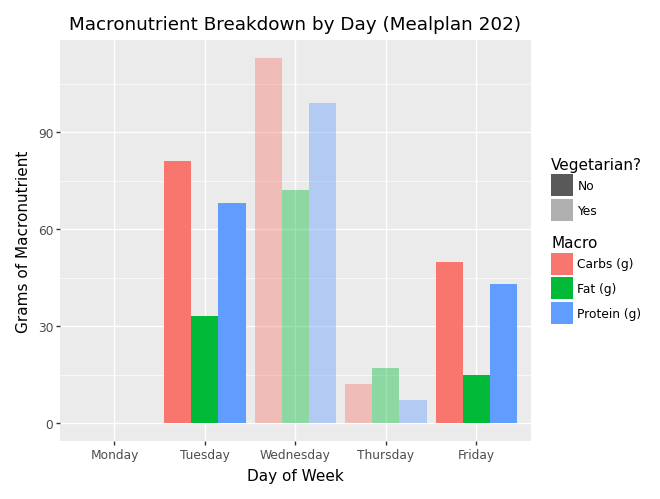

In [28]:
macros = df202.melt(
    id_vars=["Day", "Vegetarian?"],
    value_vars=["Protein (g)", "Fat (g)", "Carbs (g)"],
    var_name="Macro",
    value_name="Grams"
)
# melt to make the macros their own type of rows

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
macros['Day'] = pd.Categorical(macros['Day'], categories=day_order, ordered=True)

(
    ggplot(macros, aes(x="Day", y="Grams", fill="Macro", alpha = "Vegetarian?"))
    + geom_bar(stat="identity", position="dodge")
    + scale_alpha_manual(values = {"No": 1, "Yes": 0.4})
    + labs(
        title="Macronutrient Breakdown by Day (Mealplan 202)",
        x="Day of Week",
        y="Grams of Macronutrient"
    )
)